In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import os
import seaborn as sns
import statsmodels.formula.api as sm
from numpy.polynomial.polynomial import polyfit
from sklearn.model_selection import train_test_split
import sklearn
from math import sqrt
import glob

In [2]:
##import and concatenate datasets
##Mac:
# path = r'/Users/asariversjulien/Documents/Data/CSV files/Sapelo/Yearly data'
# all_files = glob.glob(path + "/*.csv")

# li = []

# for filename in all_files:
#     df = pd.read_csv(filename, index_col=None, header=0)
#     li.append(df)

# df = pd.concat(li, axis=0, ignore_index=True)

##PC:
path = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/Yearly data' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  ## more options can be specified also
#     print(df)

# df = df[df['Species_Code'] == 'A1'] ##eventually, you will want to do this

df

,B1,B2,B3,B4,B5,B6,B7,system:index,Site,Species_Code,...,Quadrat_Area,Zone,Plot,Latitude,Plant_Biomass,Sample_Size,Longitude,Date,B10,B11
0,0.0271,0.0301,0.0309,0.0551,0.0357,0.2911,0.0289,0,1,A1,...,0.25,1,1,31.538627,516.324,23,-81.422539,10/11/2000,NaN,NaN
1,0.0339,0.0488,0.0459,0.0952,0.0691,0.2915,0.0376,1,2,A1,...,0.25,1,1,31.536199,1152.400,21,-81.296118,10/11/2000,NaN,NaN
2,0.0358,0.0578,0.0494,0.1039,0.0690,0.2920,0.0332,2,3,A1,...,0.25,1,1,31.518920,710.396,20,-81.228956,10/18/2000,NaN,NaN
3,0.0315,0.0393,0.0421,0.0773,0.0630,0.2920,0.0332,3,4,A1,...,0.25,1,1,31.451676,1534.304,25,-81.365498,10/10/2000,NaN,NaN
4,0.0314,0.0533,0.0495,0.1394,0.1024,0.2911,0.0549,4,5,A1,...,0.25,1,1,31.436090,2022.264,25,-81.339919,10/10/2000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,0.0193,0.0247,0.0397,0.0358,0.0885,0.0635,0.0347,172,4,A1,...,0.25,1,56,31.451282,820.556,12,-81.366151,10/4/2019,0.2977,0.2949
3212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,173,2,A1,...,0.25,1,58,31.535648,210.604,15,-81.295100,10/11/2019,NaN,NaN
3213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,174,2,A1,...,0.25,1,62,31.536196,424.300,15,-81.295883,10/11/2019,NaN,NaN
3214,0.0297,0.0381,0.0532,0.0484,0.0789,0.0530,0.0265,175,6,A1,...,0.25,1,64,31.388000,295.636,8,-81.279858,10/9/2019,0.2980,0.2949


In [3]:
##Bands and indices

df['Sensor'] = np.where(df['Year']<2013, 'Landsat 5', 'Landsat 8') ##make sure no other sensors are being used

df['ndvi'] = np.where(df['Sensor'] == 'Landsat 5', (df['B4']-df['B3'])/(df['B4']+df['B3']), \
                      (df['B5']-df['B4'])/(df['B5']+df['B4'])) ##ndvi conditional based on whether sensor is Landsat-5 or 8

df['Blue_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B1'], df['B2'])
df['Green_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B2'], df['B3'])
df['Red_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B3'], df['B4'])
df['NIR_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B4'], df['B5'])
df['SWIR1_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B5'], df['B6'])
df['SWIR2_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B7'], df['B7'])

##IMPORTANT: again, these bands between landsat 5 and 8 may not be able to be compared directly

##Variables from Byrd et al. 2018 (make sure calculations are accurate):
df['savi'] = ((df['NIR_band']-df['Red_band'])*1.5)/(df['NIR_band']+df['Red_band']+0.5)
df['wdrvi5'] = (0.5*df['NIR_band']-df['Red_band'])/(0.5*df['NIR_band']+df['Red_band'])
df['nd_r_g'] = (df['Red_band']-df['Green_band'])/(df['Red_band']+df['Green_band'])
df['nd_g_b'] = (df['Green_band']-df['Blue_band'])/(df['Green_band']+df['Blue_band'])
df['nd_swir2_nir'] = (df['SWIR2_band']-df['NIR_band'])/(df['SWIR2_band']+df['NIR_band'])
df['nd_swir2_r'] = (df['SWIR2_band']-df['Red_band'])/(df['SWIR2_band']+df['Red_band'])

df

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(df)

,B1,B2,B3,B4,B5,B6,B7,system:index,Site,Species_Code,...,Red_band,NIR_band,SWIR1_band,SWIR2_band,savi,wdrvi5,nd_r_g,nd_g_b,nd_swir2_nir,nd_swir2_r
0,0.0271,0.0301,0.0309,0.0551,0.0357,0.2911,0.0289,0,1,A1,...,0.0309,0.0551,0.0357,0.0289,0.061945,-0.057314,0.013115,0.052448,-0.311905,-0.033445
1,0.0339,0.0488,0.0459,0.0952,0.0691,0.2915,0.0376,1,2,A1,...,0.0459,0.0952,0.0691,0.0376,0.115349,0.018182,-0.030623,0.180169,-0.433735,-0.099401
2,0.0358,0.0578,0.0494,0.1039,0.0690,0.2920,0.0332,2,3,A1,...,0.0494,0.1039,0.0690,0.0332,0.125134,0.025160,-0.078358,0.235043,-0.515682,-0.196126
3,0.0315,0.0393,0.0421,0.0773,0.0630,0.2920,0.0332,3,4,A1,...,0.0421,0.0773,0.0630,0.0332,0.085244,-0.042724,0.034398,0.110169,-0.399095,-0.118194
4,0.0314,0.0533,0.0495,0.1394,0.1024,0.2911,0.0549,4,5,A1,...,0.0495,0.1394,0.1024,0.0549,0.195747,0.169463,-0.036965,0.258560,-0.434894,0.051724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,0.0193,0.0247,0.0397,0.0358,0.0885,0.0635,0.0347,172,4,A1,...,0.0358,0.0885,0.0635,0.0347,0.126622,0.105559,-0.051656,0.232919,-0.436688,-0.015603
3212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,173,2,A1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,174,2,A1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3214,0.0297,0.0381,0.0532,0.0484,0.0789,0.0530,0.0265,175,6,A1,...,0.0484,0.0789,0.0530,0.0265,0.072932,-0.101878,-0.047244,0.165389,-0.497154,-0.292390


<AxesSubplot:xlabel='ndvi', ylabel='Plant_Biomass'>

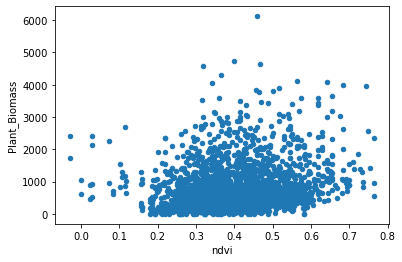

In [4]:
g = df.plot(kind = 'scatter', x = 'ndvi', y = 'Plant_Biomass')

g

# for col in df.columns:
#     print(col)

In [5]:
##Merging elevation point data with band dataset prior to model development

elev_10m = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/Point_elevation/DEM_vals_10m.csv')

elev_10m.rename(columns={'first':'Elevation'}, inplace=True)

# elev_10m = elev_10m.drop_duplicates(subset=['Latitude'])

print(elev_10m.groupby(['Latitude','Longitude']).size())

print(len(df['Latitude'].unique()))
print(len(df['Longitude'].unique()))
print(len(elev_10m['Latitude'].unique()))
print(len(elev_10m['Longitude'].unique()))

## drop rows which have same lat and long and keep latest entry
dfx = elev_10m.drop_duplicates(
  subset = ['Latitude', 'Longitude'],
  keep = 'last').reset_index(drop = True)

dfx = dfx[['Elevation', 'Latitude', 'Longitude']]
dfx['ident'] = dfx['Latitude']/dfx['Longitude'] ##Weird work around, but it works - check df comparison excel sheet

df['ident'] = df['Latitude']/df['Longitude'] ##Look at merging on multiple columns to test this

##Rationale on the 'ident' column: there are 208 unique lat/long combinations (ie locations), yet only 203 unique lats and \
##longs (some repeat, but no repeat combinations!). This 'ident' identifies unique combinations of lats and longs and can \
##be used to merge/sort the dataframes accordingly. To confirm the results, look at df_comparison excel sheet (in onedrive)

## print latest dataframe
# display(dfx)

print(len(dfx['Latitude'].unique()))
print(len(dfx['Longitude'].unique()))
print(len(dfx['ident'].unique()))
print(len(df['ident'].unique()))

# print(elev_10m)
# print(dfx)

df1 = pd.merge(df, dfx, on = 'ident') ##seems to work; check out comparison excel sheet

display(df1)
# display(df)

out_dir = os.path.expanduser('~/Downloads')
out_csv = os.path.join(out_dir, 'dfx.csv')
# dfx.to_csv(out_csv, index = False)

# df = df1 ##CAREFUL, CHECK THIS SECTION

##THE COMPARISION IS IDENTICAL

# for col in dfx.columns:
#     print(col)

Latitude   Longitude 
31.307529  -81.415324    20
31.307562  -81.415389    19
31.307641  -81.415468    19
31.307682  -81.415608    14
31.307693  -81.415592     5
                         ..
31.539429  -81.422410    19
31.539457  -81.422250    19
31.539480  -81.422098    19
31.539491  -81.421750    19
31.539505  -81.421937    19
Length: 208, dtype: int64
203
203
203
203
203
203
208
208


,B1,B2,B3,B4,B5,B6,B7,system:index,Site,Species_Code,...,savi,wdrvi5,nd_r_g,nd_g_b,nd_swir2_nir,nd_swir2_r,ident,Elevation,Latitude_y,Longitude_y
0,0.0271,0.0301,0.0309,0.0551,0.0357,0.2911,0.0289,0,1,A1,...,0.061945,-0.057314,0.013115,0.052448,-0.311905,-0.033445,-0.387345,0.489376,31.538627,-81.422539
1,0.0263,0.0404,0.0351,0.0745,0.0697,0.2883,0.0448,0,1,A1,...,0.096949,0.029717,-0.070199,0.211394,-0.248952,0.121402,-0.387345,0.489376,31.538627,-81.422539
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,A1,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.387345,0.489376,31.538627,-81.422539
3,0.0344,0.0429,0.0374,0.0798,0.0649,0.2951,0.0362,0,1,A1,...,0.103046,0.032342,-0.068493,0.109961,-0.375862,-0.016304,-0.387345,0.489376,31.538627,-81.422539
4,0.0240,0.0361,0.0321,0.0872,0.0559,0.2947,0.0309,0,1,A1,...,0.133457,0.151915,-0.058651,0.201331,-0.476715,-0.019048,-0.387345,0.489376,31.538627,-81.422539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,0.0276,0.0341,0.0453,0.0418,0.0864,0.0560,0.0294,171,6,A1,...,0.106495,0.016471,-0.040184,0.141058,-0.492228,-0.174157,-0.386172,0.514880,31.388000,-81.279858
3212,0.0249,0.0324,0.0492,0.0432,0.0930,0.0676,0.0334,166,6,A1,...,0.117416,0.036789,-0.064935,0.205882,-0.471519,-0.127937,-0.386172,0.514880,31.388000,-81.279858
3213,0.0297,0.0381,0.0532,0.0484,0.0789,0.0530,0.0265,175,6,A1,...,0.072932,-0.101878,-0.047244,0.165389,-0.497154,-0.292390,-0.386172,0.514880,31.388000,-81.279858
3214,0.0468,0.0489,0.0573,0.0643,0.1862,0.1990,0.1136,113,8,A3,...,0.243638,0.182973,0.057566,0.079096,-0.242161,0.277122,-0.384557,1.372125,31.308979,-81.415683


In [6]:
##First go at machine learning, using the methods of Byrd et al 2018

##Need (from table 3)=: SAVI, normalized difference green/blue index, wide dynamic range vegetation index 5, ndvi red/green, \
##  ndvi swir2/nir, ndvi swir2/red, site? (site may be important when combining GA, VA, and MA data)

##Random Forest test! REMEMBER: by combining landsat 5 and 8 bands, you are grouping bands with slightly different wavelengths. 
##ONLY INDICES to account for this

##From: https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/

df1 = df1[df1['ndvi'].notna()] ##remove rows with NaN for columns used in the model 
df1 = df1[df1['Species_Code'] == 'A1'] ##careful here

from sklearn.model_selection import train_test_split
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xargs=df1[['ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation']] ##Elevation added

##ELEVATION NEEDS TO BE TRIPLE-CHECKED AT EACH PLOT TO MAKE SURE VALUES CORRESPOND

yargs=df1['Plant_Biomass'] 

size_x = 0.2
seed = 42 ##play around with this
xargs_train, xargs_test, yargs_train, yargs_test = train_test_split(xargs, yargs, test_size=size_x, random_state = seed) 
## 80% training and 20% test

## Feature Scaling - is this necessary?
# from sklearn.preprocessing import StandardScaler

# sc = StandardScaler()
# xargs_train = sc.fit_transform(xargs_train)
# xargs_test = sc.transform(xargs_test)

from sklearn.ensemble import RandomForestRegressor

reg_x=RandomForestRegressor(n_estimators=100, random_state = 0) ##play with random state

##Train the model using the training sets y_pred=clf.predict(xargs_test)
reg_x.fit(xargs_train, yargs_train)
y_pred=reg_x.predict(xargs_test)

from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(yargs_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(yargs_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yargs_test, y_pred)))

r_square = metrics.r2_score(yargs_test, y_pred)
print(r_square)
print(reg_x.score(xargs_test, yargs_test))


Mean Absolute Error: 341.80385001869394
Mean Squared Error: 244059.52538435676
Root Mean Squared Error: 494.0238105439421
0.36903833171013245
0.36903833171013245


In [15]:
# TODO

# Baselines:
# - always predict the mean biomass - compare to prediction from models
# - linear regression (done) (with scikit tools; in order to single out variable)
# - PCA in pipeline
# - means/sd with different 
# - KNN regressor: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html
# - Treat as classification for new model
# - Error metrics for telling how well the model works
# - Cross validation: leave one group out (LOGO) - look this up - be careful with nearest neighbor and grouping by site
# - LOGO: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneGroupOut.html

# # Pipeline example:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
pipe = Pipeline([('scaler', StandardScaler()), ('forest', RandomForestRegressor(n_estimators=100, random_state=seed))])
pipe.fit(xargs_train, yargs_train)
y_pred=pipe.predict(xargs_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yargs_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(yargs_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yargs_test, y_pred)))
r_square = metrics.r2_score(yargs_test, y_pred)
print(r_square)
print(pipe.score(xargs_test, yargs_test))

# Mean
print('MEAN BASELINE:')
y_pred_mean = [np.mean(yargs_train)] * len(yargs_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yargs_test, y_pred_mean))



Mean Absolute Error: 336.09546305646074
Mean Squared Error: 238902.14603217124
Root Mean Squared Error: 488.77617171070364
0.3823715899590533
0.3823715899590533
MEAN BASELINE:
Mean Absolute Error: 453.3757772094646


In [7]:
# plt.scatter(xargs,yargs, color='red') ##plotting real points
df['Plant_Biomass'].describe()

count    3216.000000
mean      754.379802
std       695.243694
min         0.000000
25%       306.861000
50%       540.702000
75%       959.620000
max      7189.432000
Name: Plant_Biomass, dtype: float64

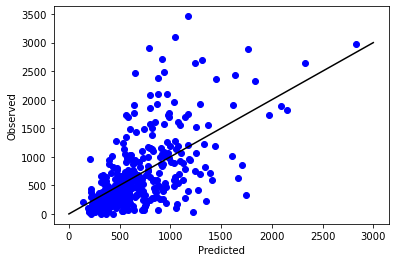

0.6076321630965899
0.9626637266313647


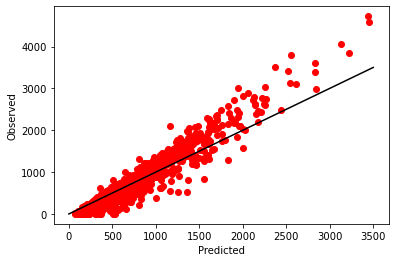

In [8]:
plt.scatter(y_pred, yargs_test, color = 'blue') ##label axes - x,y in order?
# plt.plot(X_val, regressor.predict(X_val), color = 'red')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 3000], [0, 3000], 'k-')
plt.show()

print(np.corrcoef(yargs_test, y_pred)[0, 1])

train_pred = reg_x.predict(xargs_train) ##Not sure if this is the right thing to do here
plt.scatter(train_pred, yargs_train, color = 'red')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 3500], [0, 3500], 'k-')
plt.show

print(np.corrcoef(train_pred, yargs_train)[0, 1])

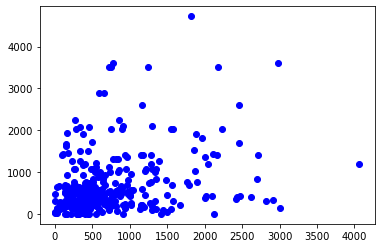

0.3118270413714948

In [18]:
plt.scatter(y_xg_test, y_xg_pred, color = 'blue') ##label axes - x,y in order?
# plt.plot(X_val, regressor.predict(X_val), color = 'red')
plt.show()

np.corrcoef(y_xg_test, y_xg_pred)[0, 1]

In [13]:
##k-fold cross validation; similar to original random forest regression code

predictors = df1[['ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation']]
targets = df1['Plant_Biomass'] 

from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import KFold, cross_validate
from sklearn.datasets import load_boston

X, y = predictors, targets
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True)

model = reg_x
scoring=('r2', 'neg_root_mean_squared_error')

cv_results = cross_validate(model, X, y, cv=kf, scoring=scoring, return_train_score=False)
cv_results

##from: https://stackoverflow.com/questions/55270431/how-to-correctly-perform-cross-validation-in-scikit-learn

{'fit_time': array([0.61413884, 0.63351727, 0.61901879, 0.63611317, 0.63331366]),
 'score_time': array([0.0129652 , 0.01295924, 0.01562166, 0.01296473, 0.0119679 ]),
 'test_r2': array([0.29737093, 0.29325736, 0.20816419, 0.28453894, 0.42205492]),
 'test_neg_root_mean_squared_error': array([-491.57228097, -523.49118397, -583.70215624, -423.88606872,
        -475.58856463])}

In [16]:
##Comparing with standard empirical model -- just uncomment and run

##sklearn - linear_regressor L1 weights look at these

print(len(xargs))
print(len(yargs))

print(xargs.head())

from sklearn import linear_model
import statsmodels.api as sm

regr = linear_model.LinearRegression()
regr.fit(xargs, yargs)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
xargs = sm.add_constant(xargs) ##adding a constant
 
model = sm.OLS(yargs, xargs).fit()
predictions = model.predict(xargs) 
 
print_model = model.summary()
print(print_model) ##check model assumptions

1883
1883
       ndvi  nd_swir2_r  nd_swir2_nir    nd_g_b    nd_r_g    wdrvi5      savi  \
0  0.281395   -0.033445     -0.311905  0.052448  0.013115 -0.057314  0.061945   
1  0.359489    0.121402     -0.248952  0.211394 -0.070199  0.029717  0.096949   
3  0.361775   -0.016304     -0.375862  0.109961 -0.068493  0.032342  0.103046   
4  0.461861   -0.019048     -0.476715  0.201331 -0.058651  0.151915  0.133457   
5  0.291521    0.002453     -0.289275  0.022876 -0.012945 -0.046312  0.112020   

   Elevation  
0   0.489376  
1   0.489376  
3   0.489376  
4   0.489376  
5   0.489376  
Intercept: 
 4121.640297965664
Coefficients: 
 [-8577.23169401 -2155.11854535  1786.02354846   251.07148876
  -314.14072088  9792.67289188  1329.57593944  -469.71117182]
                            OLS Regression Results                            
Dep. Variable:          Plant_Biomass   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.115
Method

In [15]:
##Some more plots

# sorted(sklearn.metrics.SCORERS.keys())

In [16]:
##xgboost - seems to perform worse than random forest, at least with initial data
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## split data into X and y
xargs=df1[['ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation']] 
yargs=df1['Plant_Biomass'] 

## split data into train and test sets
size_x = 0.2
seed = 0
x_xg_train, x_xg_test, y_xg_train, y_xg_test = train_test_split(xargs, yargs, test_size=size_x, random_state = seed)

##fit model no training data
xg_reg = XGBClassifier()
xg_reg.fit(x_xg_train, y_xg_train)

##make predictions for test data
y_xg_pred = xg_reg.predict(x_xg_test)
# predictions = [round(value) for value in y_pred]

##evaluate predictions

from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_xg_test, y_xg_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_xg_test, y_xg_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_xg_test, y_xg_pred)))

r_square = metrics.r2_score(y_xg_test, y_xg_pred)
print(r_square)
# print(reg_x.score(x_xg_test, y_xg_test))

# accuracy = accuracy_score(yargs_test, predictions)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

C:\ProgramData\Anaconda3\envs\venv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:48:23] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Mean Absolute Error: 496.17986206896546
Mean Squared Error: 585693.9861468859
Root Mean Squared Error: 765.306465507045
-0.5437857976558502


In [17]:
print(len(xargs_test))
print(len(xargs_train))

377
1506
